In [98]:
import pandas as pd          
import numpy as np          # For mathematical calculations
import matplotlib.pyplot as plt  # For plotting graphs
from datetime import datetime    # To access datetime
from pandas import Series        # To work on series
import matplotlib
import warnings                   # To ignore the warnings
warnings.filterwarnings("ignore")
from math import sqrt
from sklearn.metrics import mean_squared_error
from numpy import array
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats

In [99]:
df = pd.read_csv('PRSA_data.csv')

df = df.drop(['Ir','No','Is'],axis = 1)

#Changing the column names
cnames = list(df.columns)

#Drop the first row 
df = df[24:]

df.dtypes

df.reset_index(inplace = True)
df = df.drop(['index'], axis = 1)

df_new = df[['year', 'month', 'day', 'hour']]
df_new['date'] = pd.to_datetime(df_new)

df['date'] = df_new['date']

#Set the date as Index
df = df.set_index(df['date'],drop = False)
df = df.sort_index()

# df_cbwd = df['cbwd']
# df_cbwd['cbwd_mode'] = df_cbwd.resample("d").apply(lambda x: stats.mode(x)[0])

# df = df.resample('d').mean()
# df['cbwd'] = df_cbwd['cbwd_mode']

df['day_of_week'] = df.index.dayofweek

def weekend(row):
    if (row == 5) or (row == 6):
        return 1
    else:
        return 0

df['weekend'] = df['day_of_week'].apply(weekend)


mean = df['pm2.5'].min()
std_dev = df['pm2.5'].max() - df['pm2.5'].min()

for field in cnames:
    print(field, df[field].isna().sum())

df['pm2.5'] = df['pm2.5'].fillna(df['pm2.5'].mean())

df = pd.get_dummies(df, columns = ['cbwd'] )    

df['PM2.5'] = df['pm2.5']
df = df.drop(['pm2.5'], axis = 1)

df = df.drop(['hour', 'date'], axis = 1)

cnames = list(df.columns)

year 0
month 0
day 0
hour 0
pm2.5 2043
DEWP 0
TEMP 0
PRES 0
cbwd 0
Iws 0


In [100]:
df.head()

,year,month,day,DEWP,TEMP,PRES,Iws,day_of_week,weekend,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv,PM2.5
date,,,,,,,,,,,,,,
2010-01-02 00:00:00,2010,1,2,-16,-4.0,1020.0,1.79,5,1,0,0,1,0,129.0
2010-01-02 01:00:00,2010,1,2,-15,-4.0,1020.0,2.68,5,1,0,0,1,0,148.0
2010-01-02 02:00:00,2010,1,2,-11,-5.0,1021.0,3.57,5,1,0,0,1,0,159.0
2010-01-02 03:00:00,2010,1,2,-7,-5.0,1022.0,5.36,5,1,0,0,1,0,181.0
2010-01-02 04:00:00,2010,1,2,-7,-5.0,1022.0,6.25,5,1,0,0,1,0,138.0


In [101]:
df = df.resample('d').mean()

In [102]:
df.head()

,year,month,day,DEWP,TEMP,PRES,Iws,day_of_week,weekend,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv,PM2.5
date,,,,,,,,,,,,,,
2010-01-02,2010.0,1.0,2.0,-8.500000,-5.125000,1024.750000,24.860000,5.0,1.0,0.000,0.000000,1.00,0.000000,145.958333
2010-01-03,2010.0,1.0,3.0,-10.125000,-8.541667,1022.791667,70.937917,6.0,1.0,0.000,0.166667,0.75,0.083333,78.833333
2010-01-04,2010.0,1.0,4.0,-20.875000,-11.500000,1029.291667,111.160833,0.0,0.0,0.000,1.000000,0.00,0.000000,31.333333
2010-01-05,2010.0,1.0,5.0,-24.583333,-14.458333,1033.625000,56.920000,1.0,0.0,0.375,0.583333,0.00,0.041667,42.458333
2010-01-06,2010.0,1.0,6.0,-23.708333,-12.541667,1033.750000,18.511667,2.0,0.0,0.500,0.416667,0.00,0.083333,56.416667


In [103]:
df = df.iloc[:-2,:]

In [104]:
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

for field in cnames:
    df[field] = (df[field] - df[field].min())/(df[field].max() - df[field].min())

# choose a number of time steps
n_steps_in, n_steps_out = 15, 4

X, y = split_sequences(df.values, n_steps_in, n_steps_out)

X_test, y_test = X[-1], y[-1]

for i in range(n_steps_out):
	X = np.delete(X, X.shape[0] - 1, 0)
	y = np.delete(y, y.shape[0] - 1, 0)

n_features = X.shape[2]


In [105]:
df.head()

,year,month,day,DEWP,TEMP,PRES,Iws,day_of_week,weekend,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv,PM2.5
date,,,,,,,,,,,,,,
2010-01-02,0.0,0.0,0.033333,0.417075,0.197183,0.621417,0.050777,0.833333,1.0,0.000000,0.000000,1.00,0.000000,0.269502
2010-01-03,0.0,0.0,0.066667,0.389783,0.125000,0.581788,0.150561,1.000000,1.0,0.000000,0.166667,0.75,0.083333,0.142996
2010-01-04,0.0,0.0,0.100000,0.209237,0.062500,0.713322,0.237666,0.000000,0.0,0.000000,1.000000,0.00,0.000000,0.053476
2010-01-05,0.0,0.0,0.133333,0.146956,0.000000,0.801012,0.120205,0.166667,0.0,0.391304,0.583333,0.00,0.041667,0.074443
2010-01-06,0.0,0.0,0.166667,0.161652,0.040493,0.803541,0.037029,0.333333,0.0,0.521739,0.416667,0.00,0.083333,0.100749


In [106]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Bidirectional
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import GRU
from keras.layers.normalization import BatchNormalization

model = Sequential()
model.add(Bidirectional(GRU(50, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features))))
model.add(Bidirectional(GRU(50, activation='relu')))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='RMSProp', loss='mse')

print('SUCCESS!!')

SUCCESS!!


In [107]:
from tensorflow.keras.callbacks import EarlyStopping

monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=50, verbose=1, mode='auto',
        restore_best_weights=True)
model.fit(X, y, callbacks=[monitor], verbose=2, epochs=1000)

#from sklearn.externals import joblib 
#path = "/content/drive/My Drive/Journal_models/model_lstm_50back.pkl"  
# Save the model as a pickle in a file 
#joblib.dump(model, path) 

# # fit model
# model.fit(X, y, epochs=2000, verbose=2)

Epoch 1/1000
 - 4s - loss: 0.0218
Epoch 2/1000
 - 2s - loss: 0.0187
Epoch 3/1000
 - 2s - loss: 0.0174
Epoch 4/1000
 - 2s - loss: 0.0167
Epoch 5/1000
 - 2s - loss: 0.0162
Epoch 6/1000
 - 2s - loss: 0.0158
Epoch 7/1000
 - 2s - loss: 0.0153
Epoch 8/1000
 - 2s - loss: 0.0151
Epoch 9/1000
 - 2s - loss: 0.0146
Epoch 10/1000
 - 2s - loss: 0.0141
Epoch 11/1000
 - 2s - loss: 0.0139
Epoch 12/1000
 - 2s - loss: 0.0136
Epoch 13/1000
 - 2s - loss: 0.0129
Epoch 14/1000
 - 2s - loss: 0.0129
Epoch 15/1000
 - 2s - loss: 0.0124
Epoch 16/1000
 - 2s - loss: 0.0121
Epoch 17/1000
 - 2s - loss: 0.0117
Epoch 18/1000
 - 2s - loss: 0.0112
Epoch 19/1000
 - 2s - loss: 0.0108
Epoch 20/1000
 - 2s - loss: 0.0104
Epoch 21/1000
 - 2s - loss: 0.0102
Epoch 22/1000
 - 2s - loss: 0.0097
Epoch 23/1000
 - 2s - loss: 0.0094
Epoch 24/1000
 - 2s - loss: 0.0091
Epoch 25/1000
 - 2s - loss: 0.0088
Epoch 26/1000
 - 2s - loss: 0.0087
Epoch 27/1000
 - 2s - loss: 0.0084
Epoch 28/1000
 - 2s - loss: 0.0080
Epoch 29/1000
 - 2s - loss: 0

In [108]:
x_input = array(X_test)
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=2)
print((yhat[0]*std_dev)+mean)
print((y_test*std_dev)+mean)

[239.42735  209.99925  251.315     50.249203]
[313.39075108 441.55703085 364.20454409 292.31590605]


In [109]:
y_test = (y_test*std_dev)+mean
yhat = (yhat[0]*std_dev)+mean
print(yhat)
print(y_test)

[239.42735  209.99925  251.315     50.249203]
[313.39075108 441.55703085 364.20454409 292.31590605]


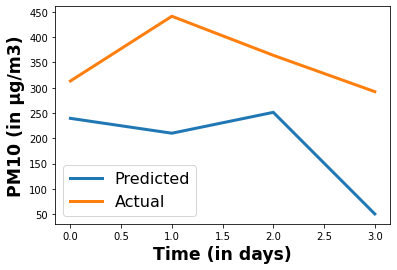

In [110]:
plt.plot((yhat),label = 'Predicted', linewidth = 3)
plt.plot((y_test), label = 'Actual', linewidth = 3)
plt.xlabel('Time (in days)', fontsize = 'xx-large', fontweight = 'bold')
plt.ylabel('PM10 (in µg/m3)', fontsize = 'xx-large', fontweight = 'bold')
plt.legend(prop = {'size': 16})
plt.show()

In [111]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
def mean_absolute_percentage_error(y_true, y_pred): 
   return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


rms_new = sqrt(mean_squared_error(y_test, yhat))
print(rms_new)

mse_new = mean_squared_error(y_test, yhat)
print(mse_new)

mae_new = mean_absolute_error(y_test, yhat)
print(mae_new)

mape_new = mean_absolute_percentage_error(y_test, yhat)
print(mape_new)

180.5754181338437
32607.481634212487
165.1193554181949
47.46209192156509
